# Profiling, Testing, and Advanced interactivity

::::: {.grid}

:::: {.g-col-6}

::: {.callout-note appearance="minimal"}
## Lecture learning goals

1. See how callbacks are connected using the callback graph.
2. View overall timings of 
3. Learn how to profile a Dash app more granually using `ctx`.
4. Communicate that a computation is underway via spinners
5. Test regular callback functions in Dash
6. Test callback functions that require the callback context to be mocked.
7. Understand how more advanced interactivity can also be created client side without a full dashboarding library.


:::
    
::::

:::: {.g-col-6}

::: {.callout-note appearance="minimal"}
## Optional activities

- None this week

:::

::::

:::::

**Lecture slides**

No slides this week.

## Profiling

Last lecture we learned a few general tips of how to speed up code
and what types of patterns to avoid.
This lecture we will learn how to profile code to understand what is slow in our particular app.
In the context of Dash apps,
you can profile code by enabling `debug=True` in the `app.run` method.
This gives access to the small blue button in the bottom right corner of the app.
If you click it,
you will see that one of the options is called "callback graph",
and this shows both the order of the callbacks
and the time it takes to execute each one.

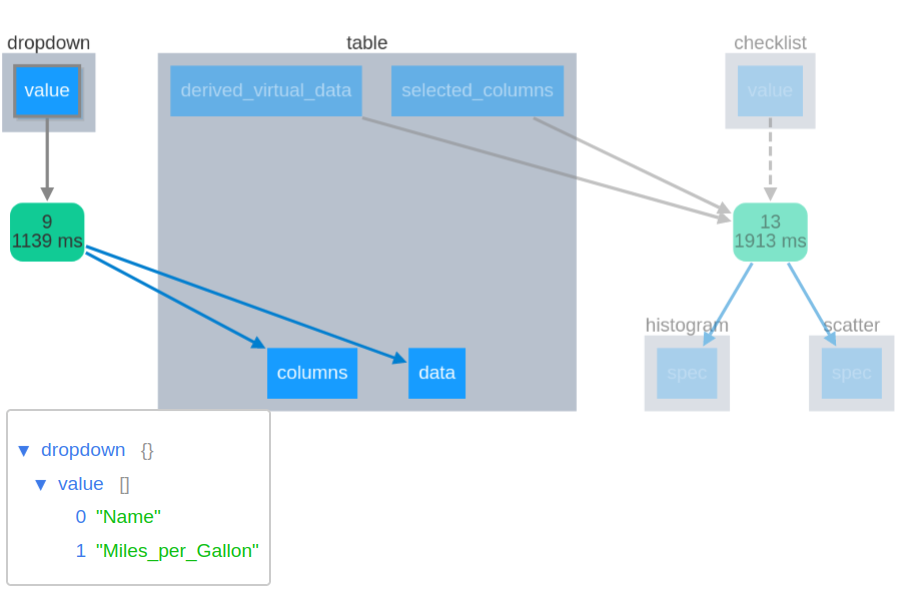

The solid lines represent `Input` components and the dashed lines `State` components.
The green boxes are the callback;
the top number sasys how many times the callback has been executed
and the bottom line is the time it took to execute it the most recent time.
If you want more detail about how long it took to execute the callback,
you can use the `ctx` (or `callback_context`) module in Dash.
This requires us to use `time.time()` to manually measure the time it takes to execute a function
and then use the `ctx` module to record the time in a way that it is accessible in the browser.
These manually recorded times will show up after clicking the green callback node in the callback graph
and expanding the time section
(you will see them as `user:your_label`):

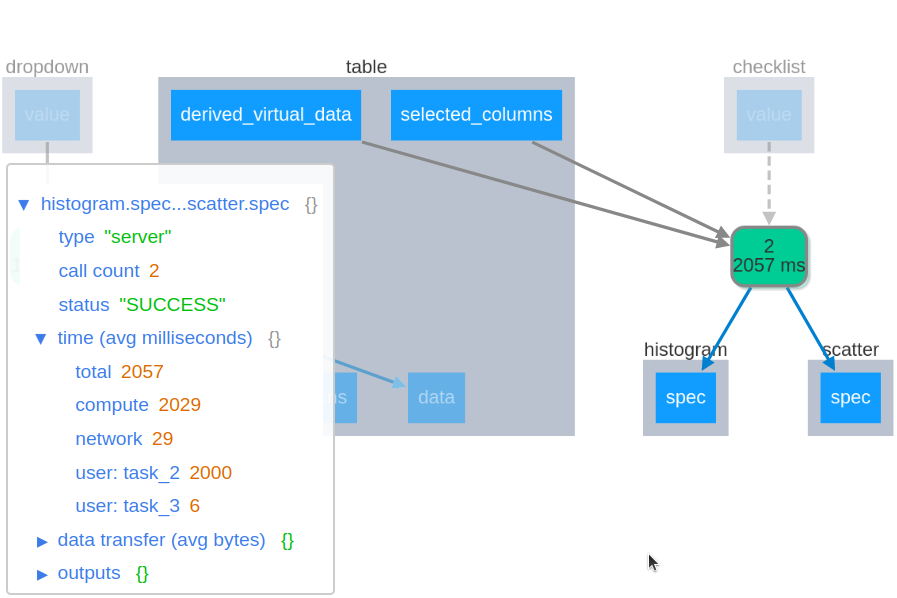

You can also see them by hitting `F12` in most browsers, going to the `Network` tab, searching for `_dash-update`, and selecting the `Timings` tab.
This is sometimes more convenient since you can leave this open as you change things in the app
and see how the timings change.

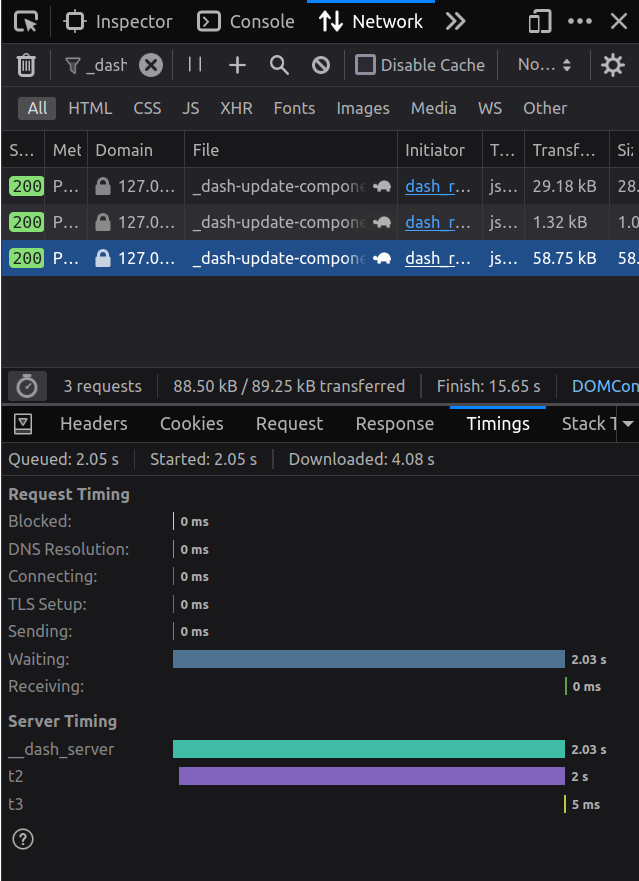

If we can't figure out how to speed up the code,
we can at least communicate to the person using the dasboard 
that a computation is under way.
A good way to do this is to use the `dcc.Loading` component,
which inserts a spinner (a type of progress indicator) in the place of the component that is being updated.
Don't go overboard with this and create too many fancy animations.

The full code for the app with both the manual timings and the spinners looks like this:

```python
from dash import Dash, dash_table, dcc, callback, Input, Output, ctx, State
import dash_bootstrap_components as dbc
import dash_vega_components as dvc
from vega_datasets import data
import pandas as pd
import altair as alt
import time


cars = data.cars()

# Initialization
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Components
table = dash_table.DataTable(
    id='table',
    # The data and columns parameters are set in the callback instead
    column_selectable="single",
    selected_columns=['Miles_per_Gallon'], 
    page_size=5,
    sort_action='native',
    filter_action='native',
)
dropdown = dcc.Dropdown(
    id='dropdown',
    options=cars.columns,
    value=['Name', 'Miles_per_Gallon', 'Horsepower'],
    multi=True
)
scatter = dcc.Loading(
    dvc.Vega(
        id='scatter',
        opt={'actions': False},  # Remove the three dots button
        style={'width': '100%'}
    ),
    type='circle'
)
histogram = dcc.Loading(
    dvc.Vega(
        id='histogram',
        opt={'actions': False},  # Remove the three dots button
        style={'width': '100%'}
    ),
    type='cube'
)

checklist = dbc.Checklist(
    id='checklist',
    options=['Use red marks?']
)

# Layout
app.layout = dbc.Container(
    dbc.Row([
        dbc.Col([checklist, dropdown, table]),
        dbc.Row([
            dbc.Col(histogram),
            dbc.Col(scatter),
        ]),
    ])
)
@callback(
    Output('table', "columns"),
    Output('table', "data"),
    Input('dropdown', "value"),
)
def update_table(dropdown_cols):
    start = time.time()
    time.sleep(1)  # Some complex computation
    ctx.record_timing('task_1', time.time() - start, 't1')

    return(
        [  # A list of dictionaries, each representing a column
            {
                "name": col.replace('_', ' '),
                "id": col,
                'selectable': False if col == 'Name' else True
            }
            for col in dropdown_cols
        ],
        cars[dropdown_cols].to_dict('records')
)


@callback(
    Output('histogram', "spec"),
    Output('scatter', "spec"),
    Input('table', "derived_virtual_data"),
    Input('table', "selected_columns"),
    State('checklist', 'value'), 
    prevent_initial_call=True  # Avoid triggering before the table has a selected column
)
def update_(table_rows, table_column, checklist):
    start = time.time()
    time.sleep(2)  # Complex comp 2
    ctx.record_timing('task_2', time.time() - start, 't2')

    start = time.time()
    color = 'coral' if checklist is not None else 'steelblue'
    histogram = alt.Chart(pd.DataFrame(table_rows), width='container').mark_bar(color=color).encode(
        alt.X(f'{table_column[0]}:Q').bin(maxbins=30),
        alt.Y('count()')
    )
    scatter = alt.Chart(pd.DataFrame(table_rows), width='container').mark_area(color=color).transform_density(
        table_column[0],
        as_=[table_column[0], 'density']
    ).encode(
        alt.X(f'{table_column[0]}:Q'),
        alt.Y('density:Q'),
    )
    ctx.record_timing('task_3', time.time() - start, 't3')
    return histogram.to_dict(), scatter.to_dict()


if __name__ == '__main__':
    app.run(debug=True)
```

To perform profiling in function at an even deeper level,
we could break out the function we are interested in to a separate script 
or notebook and use `%%prun` together with `%%snakeviz` as you learned in 512.
Here is a brief example as a reminder:

```python
import time
import pandas as pd

df_parquet = pd.read_parquet('nyc-taxi_1-000-000-rows.parquet')[:100_000]

def slow_function(input):
    [i ** i for i in range(1_000)]
    time.sleep(5)
    df_parquet.apply(lambda x: x['total_amount'] - x['fare_amount'] - x['tip_amount'], axis=1)
    return f'Input was {input}'
```

```python
%%prun -l 10 -s cumulative # show the top 10 lines
slow_function('hey')
```

```text
         6400604 function calls (6400586 primitive calls) in 7.676 seconds

   Ordered by: cumulative time
   List reduced from 184 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    7.676    7.676 {built-in method builtins.exec}
        1    0.000    0.000    7.675    7.675 <string>:1(<module>)
        1    0.011    0.011    7.675    7.675 4236105617.py:6(slow_function)
        1    5.000    5.000    5.000    5.000 {built-in method time.sleep}
        1    0.000    0.000    2.643    2.643 frame.py:9864(apply)
        1    0.002    0.002    2.643    2.643 apply.py:804(apply)
        1    0.000    0.000    2.641    2.641 apply.py:964(apply_standard)
        1    0.112    0.112    2.614    2.614 apply.py:970(apply_series_generator)
   100000    0.105    0.000    2.012    0.000 4236105617.py:9(<lambda>)
   300000    0.529    0.000    1.907    0.000 series.py:1016(__getitem__)
```

Above we can see the names of the functions that were called.
There is some boilerplate first showing that python is `exec`-ing the code,
then the function we are interested in is called `slow_function`,
and inside that function we can see that the `apply` method is taking up a lot of time.

`snakeviz` shows the same information but with an interactive visualization
allowing us to drill down further:

```python
%load_ext snakeviz
```

```python
%%snakeviz
slow_function('hey')
```

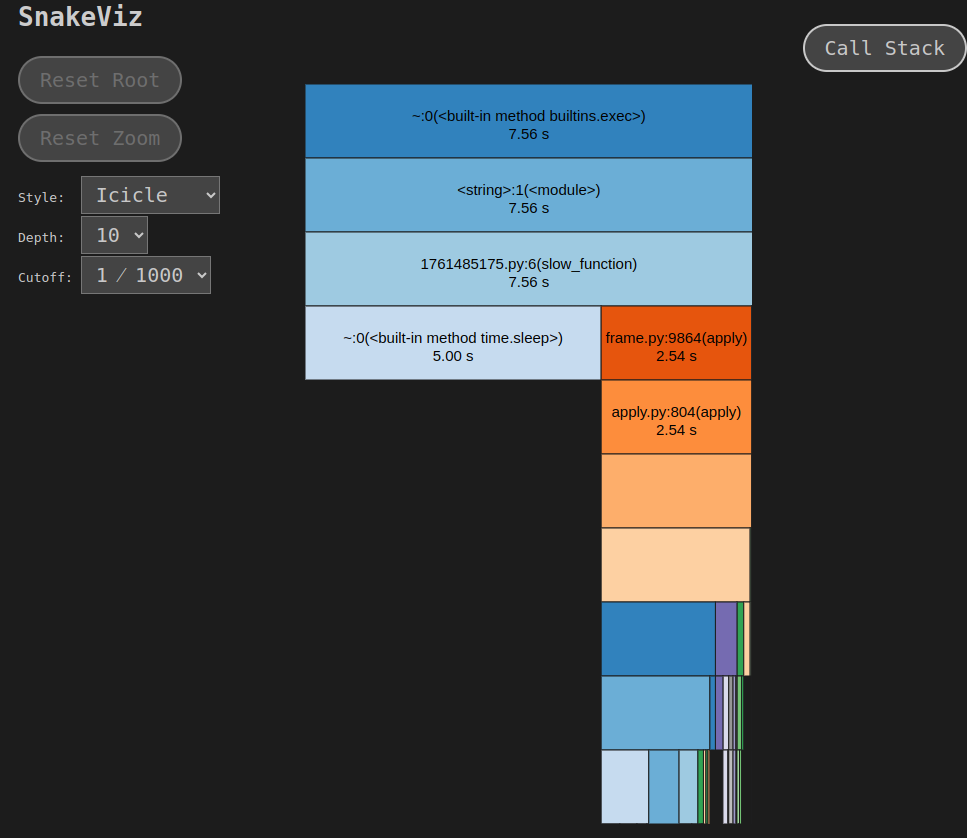

## Testing

To test dash apps, you can use a combination of standard unit tests
and tests that take into account Dash callback state.
Here is an examle of an app that contains two callback functions:

- `update`, which does not depend on the callback context (i.e. it performs the same type of update regardless of which button was clicked).
- `display`, which does depend on the callback context (i.e. it displays a different message depending on which button was clicked).

```python
from dash import Dash, callback, html, Input, Output, ctx

app = Dash(__name__)

app.layout = html.Div([
    html.Button('Button 1', id='btn-1'),
    html.Button('Button 2', id='btn-2'),
    html.Button('Button 3', id='btn-3'),
    html.Div(id='container'),
    html.Div(id='container-no-ctx')
])

@callback(
    Output('container-no-ctx', 'children'),
    Input('btn-1', 'n_clicks'),
    Input('btn-2', 'n_clicks'))
def update(btn1, btn2):
    return f'button 1: {btn1} & button 2: {btn2}'


@callback(Output('container','children'),
              Input('btn-1', 'n_clicks'),
              Input('btn-2', 'n_clicks'),
              Input('btn-3', 'n_clicks'))
def display(btn1, btn2, btn3):
    button_clicked = ctx.triggered_id
    return f'You last clicked button with ID {button_clicked}'

if __name__ == '__main__':
    app.run(debug=True)

```

To test the `update` function, you can simply call it with some inputs and check the output, just as with any Python function.

```python
from app_test import update

def test_update_callback():
    output = update(1, 0)
    assert output == 'button 1: 1 & button 2: 0'
```

To test the `display` function, you need to mock the callback context to simulate the trigger that you want to test.
In this case,
we are imitating the trigger that would happen if button 1 was clicked,
and make sure that our message matches the expected output.

```python
# These are needed to mock the callback context in the second test
from contextvars import copy_context
from dash._callback_context import context_value
from dash._utils import AttributeDict

from app_test import display

# Mock the callback context to test a callback with different output
# depending on which input was triggered
# Mocking the callback context can simulate specific triggers and inputs
# without requiring actual user interaction.
def test_display_callback():

    def run_callback(trigger):
        context_value.set(AttributeDict(**{"triggered_inputs": [trigger]}))
        return display(1, 0, 0)  # Call signature when button 1 is clicked, but not important since none of these inputs actually impact the output

    ctx = copy_context()
    trigger = {"prop_id": "btn-1-ctx-example.n_clicks"}
    output = ctx.run(run_callback, trigger)
    assert output == 'You last clicked button with ID btn-1-ctx-example'
```

You could put both these functions in the same file called something like `test_app_callbacks.py` and run them with `pytest test_app_callbacks.py`.

You could perform more advanced testing with dash too,
such as using a browser mock package like `selenium` to simulate user interaction. You can find details on how to do this and other testing best pratctices in [this blog post from the Plotly team](https://plotly.com/blog/building-unit-tests-for-dash-applications/) and [the Dash docs](https://dash.plotly.com/testing)

## Dash extensions

There are many third party libraries that can be used to extend Dash.
Here are a couple of examples
that could be worth checking out if there is something that doesn't work quite the way you want it to:

- https://www.dash-mantine-components.com/
    - Additional components for Dash; e.g. a multi-select dropdown with a max limit and date pickers that allow to select months and years separately.
- https://www.ag-grid.com/
    - More stylish and powerful tables than DataTable

## Advanced client side interactivity

I didn't want to upload the data for this example to the repo,
so I've included a couple of examples showing the same functionliaty,
but with other data.
These are also less complex overall,
so it is easier to see what is going on.

The first one shows the "reveal" functionality,
where you can drag a slider to show an alternate visualization.
In this case it is an aggregation/binning of the data,
but it could be anything you want.
This uses `transform_filter` together with a "Vega expression":
`alt.datum["IMDB_Rating"] >= threshold`,
to only show the one layer when the values are larger than the threshold/slider.

In [1]:
import altair as alt
from vega_datasets import data

source = data.movies.url

slider = alt.binding_range(min=0, max=10, step=0.1)
threshold = alt.param(name="threshold", value=5, bind=slider)

alt.layer(
    alt.Chart(source).mark_circle().encode(
        x=alt.X("IMDB_Rating:Q").title("IMDB Rating"),
        y=alt.Y("Rotten_Tomatoes_Rating:Q").title("Rotten Tomatoes Rating")
    ).transform_filter(
        alt.datum["IMDB_Rating"] >= threshold
    ),

    alt.Chart(source).mark_circle().encode(
        x=alt.X("IMDB_Rating:Q").bin(maxbins=10),
        y=alt.Y("Rotten_Tomatoes_Rating:Q").bin(maxbins=10),
        size=alt.Size("count():Q").scale(domain=[0,160])
    ).transform_filter(
        alt.datum["IMDB_Rating"] < threshold
    ),

    alt.Chart().mark_rule(color="gray").encode(
        strokeWidth=alt.StrokeWidth(value=6),
        x=alt.X(datum=alt.expr(threshold.name), type="quantitative")
    )
).add_params(threshold)

alt.LayerChart(...)

This next example shows how to reorder the bar segments when the legend is clicked.
This is a bit more complex,
in the sense that it uses an if condition insdie the Vega expression
to compute a new field for the order of the segments.
This values of this field are going to be `0` if the field is clicked in the legend
and `1` otherwise.
Vega expressions don't have an `in` operator,
so instead we check if the result of `indexof` is `-1`,
which means that the name was not found in the array of clicked names.

In [2]:
import altair as alt
from vega_datasets import data

selection = alt.selection_point(fields=['site'], bind='legend')

source = data.barley.url

alt.Chart(source).mark_bar().transform_calculate(
    site_order=f"if({selection.name}.site && indexof({selection.name}.site, datum.site) !== -1, 0, 1)"
).encode(
    x='sum(yield):Q',
    y='variety:N',
    color='site:N',
    order='site_order:N',
    opacity=alt.condition(selection, alt.value(0.9), alt.value(0.2))
).add_params(
    selection
)

alt.Chart(...)